### Importing nesccessry libraries 

In [1]:
import numpy as np 
from matplotlib import pyplot as plt 
from networkx import path_graph,incidence_matrix
from qpsolvers import solve_qp
import scipy
from time import time
from pyswarm import pso
from numba import jit
import seaborn as sns
from datetime import datetime

### Plotting function 

In [2]:
def plot_vehicle_control_analysis(velocities, relative_d, U, n):
    """
    Plot vehicle control system analysis with three subplots.
    
    Parameters:
    -----------
    velocities : numpy.ndarray
        Vehicle velocities data
    relative_d : numpy.ndarray
        Relative distances data
    U : numpy.ndarray
        Control effort data
    n : int
        Number of vehicles/colors for the plot
    """
    # Set style
    sns.set_style("whitegrid")
    plt.rcParams.update({'font.size': 12})

    # Create figure
    fig = plt.figure(figsize=(20, 6))
    fig.suptitle('Vehicle Control System Analysis', fontsize=16, y=1.05)

    # Color palette
    colors = sns.color_palette("husl", n_colors=n)

    # Subplot 1: Vehicle Velocities
    plt.subplot(1, 3, 1)
    plt.plot(velocities[:,:].T, linewidth=1.5, alpha=0.7)
    plt.xlabel('Time Steps (×0.02 seconds)', fontweight='bold')
    plt.ylabel('Vehicle Velocity', fontweight='bold')
    plt.title('Vehicle Velocities over Time', pad=20)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Subplot 2: Relative Distances
    plt.subplot(1, 3, 2)
    plt.plot(relative_d[:,:].T, linewidth=1.5, alpha=0.7)
    plt.axhline(y=1.5, color='red', linestyle='--', label='Safety Boundary', linewidth=2)
    plt.legend(loc='upper right', frameon=True, fancybox=True, shadow=True)
    plt.xlabel('Time Steps (×0.02 seconds)', fontweight='bold')
    plt.ylabel('Relative Distances', fontweight='bold')
    plt.title('Relative Distance over Time', pad=20)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Subplot 3: Control Effort
    plt.subplot(1, 3, 3)
    plt.plot(U[:,:].T, linewidth=1.5, alpha=0.7)
    plt.xlabel('Time Steps (×0.02 seconds)', fontweight='bold')
    plt.ylabel('Control Effort', fontweight='bold')
    plt.title('Control Effort over Time', pad=20)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Add timestamp
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    plt.figtext(0.99, 0.01, f'Generated: {timestamp}', ha='right', va='bottom', fontsize=8)

    # Adjust layout
    plt.tight_layout()
    plt.show()

### VP with PI

#### Actual code

In [62]:
class VP():
    def __init__(self,size:int,incidenceMatrix:np.ndarray,proportional_term:float,
                 intergration_term:float
                 ,delta_t = 0.01,dtype = 'float32',solver = 'osqp',steps= 1):
        self.steps = steps 
        self.x = 6*(np.random.random((size,1)).astype(dtype)-0.5) + 7
        self.E = incidenceMatrix
        self._kappa = 2* (np.random.random((size,1)) - 0.5) + 2
        self._rho = 0.5*(np.random.random((size,1)).astype(dtype)-0.5) + 3
        self._lambda =3*(np.random.random((size,1)).astype(dtype)-0.5) + 7
        self.x_bar = 7*np.ones(shape=self.x.shape)
        self._zeta = np.matmul(self.E.T,self.x)
        self._eta =  np.zeros(self._zeta.shape,dtype = dtype) + 2#(np.random.random(size = self._zeta.shape).astype(dtype)-0.5)+2# np.zeros(self._zeta.shape,dtype = dtype) + 2
        self._mu = np.tanh(self._eta)
        self.delta_t =delta_t
        self.s = np.zeros((size,1),dtype=dtype)
        self.p = proportional_term
        self.i = intergration_term
        self.u = np.matmul(-self.E,self._mu) + self.p*(self.x_bar - self.x) +self.i*self.s


    def update(self): 
        relative_d = np.zeros((self._eta.shape[0], self.steps))
        velocities = np.zeros((self.x.shape[0], self.steps))
        U = np.zeros((self.u.shape[0], self.steps))
        for step in range(self.steps):
            U[:, step] = self.u[:, 0]
            velocities[:, step] = self.x[:, 0]
            relative_d[:, step] = self._eta[:, 0]
            self._zeta = np.matmul(self.E.T,self.x)
            self._eta += self.delta_t*self._zeta
            self._mu = np.tanh(self._eta)
            self.s += self.delta_t*(self.x_bar - self.x)
            self.u = np.matmul(-self.E,self._mu) + self.p*(self.x_bar - self.x) +self.i*self.s

            self.f_x = self._kappa*(-(self.x - self._lambda) +(1/self._rho)*self.u )
            self.x += self.delta_t*self.f_x
        return U, relative_d, velocities


#### Simulation


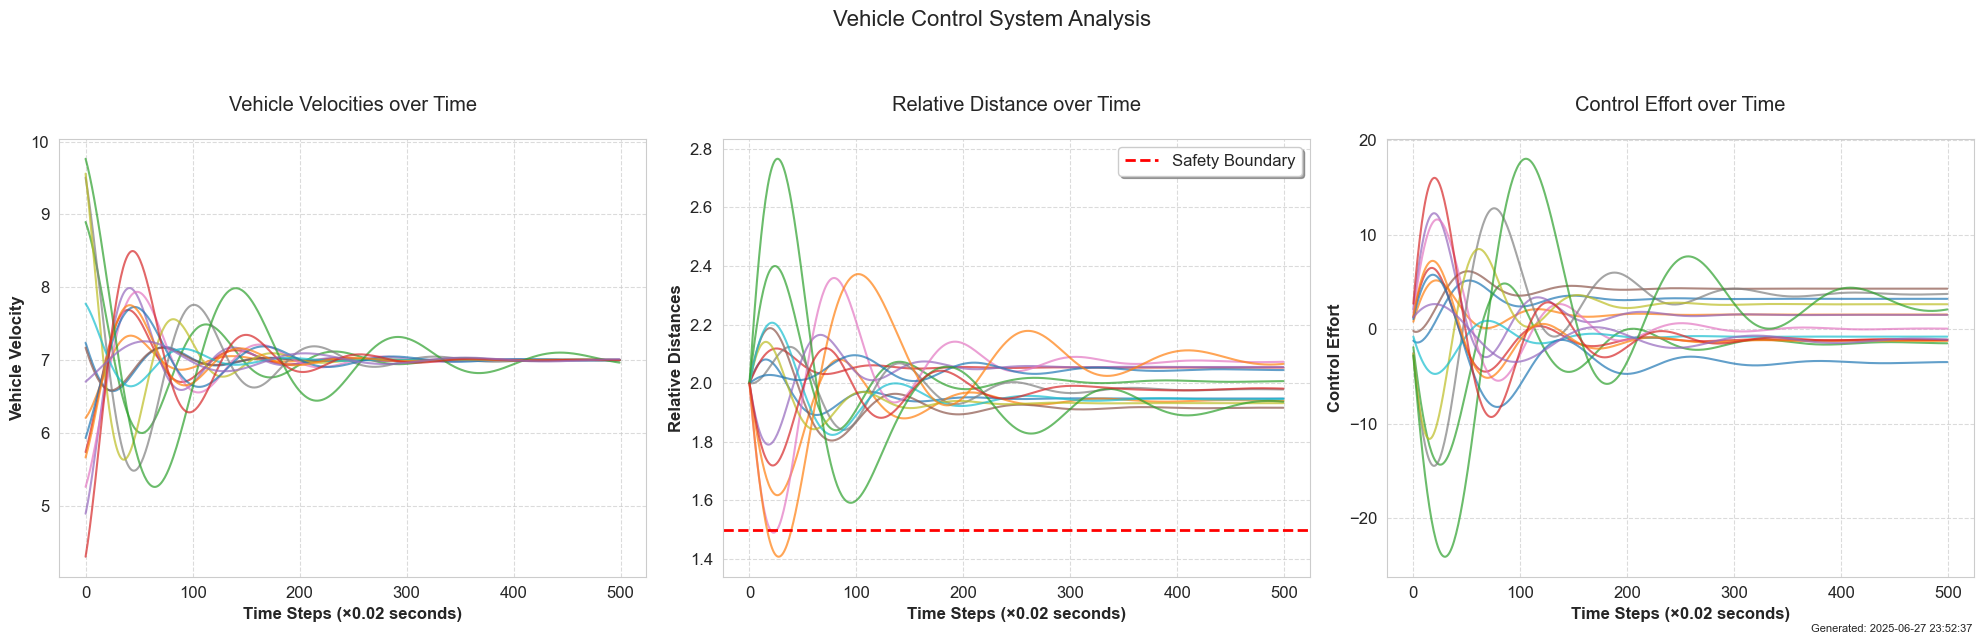

In [63]:
n = 15
delta_t = 0.01
steps = int(5*(1/delta_t))
Imatrix = -scipy.sparse.csr_matrix.toarray(incidence_matrix(path_graph(n=n), oriented=True))
graph = VP(size = n,incidenceMatrix=Imatrix,proportional_term=1,intergration_term=50,delta_t=delta_t,
            solver='daqp',steps = steps)
#### saving initial states for later use 
X = np.copy(graph.x)
Eta = np.copy(graph._eta)
Lambda = np.copy(graph._lambda)
Kappa = np.copy(graph._kappa)
Rho = np.copy(graph._rho)
Gamma = Kappa/Rho
U, relative_d, velocities = graph.update()
plot_vehicle_control_analysis(velocities, relative_d, U, n)


### VP , Nominal safety 

#### Actual code 

In [66]:
class VP():
    def __init__(self,size:int,incidenceMatrix:np.ndarray,proportional_term:float,
                 intergration_term:float
                 ,delta_t = 0.01,dtype = 'float32',solver = 'osqp',steps= 1):
        self.steps = steps
        self.dim = size
        self.x = 2*np.random.random((size,1)).astype(dtype) + 5
        self.E = incidenceMatrix
        self._kappa =1*np.ones((size,1),dtype=dtype)
        self._rho = np.random.random((size,1)).astype(dtype) + 1
        self._lambda  = np.random.random((size,1)).astype(dtype) + 5
        self.x_bar = 5.5*np.ones((size,1),dtype=dtype)
        self._zeta = np.matmul(self.E.T,self.x)
        self._eta = np.zeros(self._zeta.shape,dtype = dtype) + 2
        self._mu = np.tanh(self._eta)
        self.delta_t =delta_t
        self.s = np.zeros((size,1),dtype=dtype)
        self.p = proportional_term
        self.i = intergration_term
        self.u = np.matmul(-self.E,self._mu) + self.p*(self.x_bar - self.x) +self.i*self.s
        self.gamma = self._kappa/self._rho
        self.k1,self.k2 = (10,10)
        self.solver = solver 

    def update(self,safe=True): 
        relative_d = np.zeros((self._eta.shape[0], self.steps))
        velocities = np.zeros((self.x.shape[0], self.steps))
        U = np.zeros((self.u.shape[0], self.steps))

        for step in range(self.steps):
            U[:, step] = self.u[:, 0]
            velocities[:, step] = self.x[:, 0]
            relative_d[:, step] = self._eta[:, 0]
            self._zeta = np.matmul(self.E.T,self.x)
            self._eta += self.delta_t*self._zeta
            self._mu = np.tanh(self._eta)
            self.s += self.delta_t*(self.x_bar - self.x)
            self.u = np.matmul(-self.E,self._mu) + self.p*(self.x_bar - self.x) +self.i*self.s
            if safe: 
                P = 2*(2*np.eye(N = self.dim))
                P[0,0],P[-1,-1] = (2.0,2.0)
                q = -2*(2*self.u.T)
                q[0,0],q[0,-1] = (0.5*q[0,0],0.5*q[0,-1])
                g = -np.diag(self._eta[:,0])@(self.E.T)@np.diag(self.gamma[:,0]) #-2*(self._eta*1*self.E*self.gamma).T
                P = scipy.sparse.csc_matrix(P)
                g = scipy.sparse.csc_matrix(g)


    
                alpha_1 = self.k1*((self._eta**2) - 1.7**2) 
                alpha_2 = self.k2*(2*self._eta*(self.E.T@self.x) + alpha_1)
                
                self.alpha = alpha_2
                alpha_1_prim = self.k1*np.ones(shape=self._eta.shape)
                v = 2*(self.E.T@self.x)**2 + 2*self._eta*(self.E.T@self.x)*alpha_1_prim + alpha_2
                h = v + 2*self._eta*((-1*self.E.T)@(self._kappa*(self.x - self._lambda))) 
                self.u = solve_qp(P,q,g,h,solver='osqp').reshape((-1,1))
            # Runge-Kutta 4th order method
            # Define the system dynamics function
            def system_dynamics(x):
                return self._kappa*(-(x - self._lambda) + (1/self._rho)*self.u)
            
            # Calculate k1, k2, k3, k4
            k1 = system_dynamics(self.x)
            k2 = system_dynamics(self.x + self.delta_t * k1/2)
            k3 = system_dynamics(self.x + self.delta_t * k2/2)
            k4 = system_dynamics(self.x + self.delta_t * k3)
            
            # Update f_x using RK4
            self.f_x = (k1 + 2*k2 + 2*k3 + k4) / 6
            self.x += self.delta_t*self.f_x
        return U, relative_d, velocities





#### Simulation 

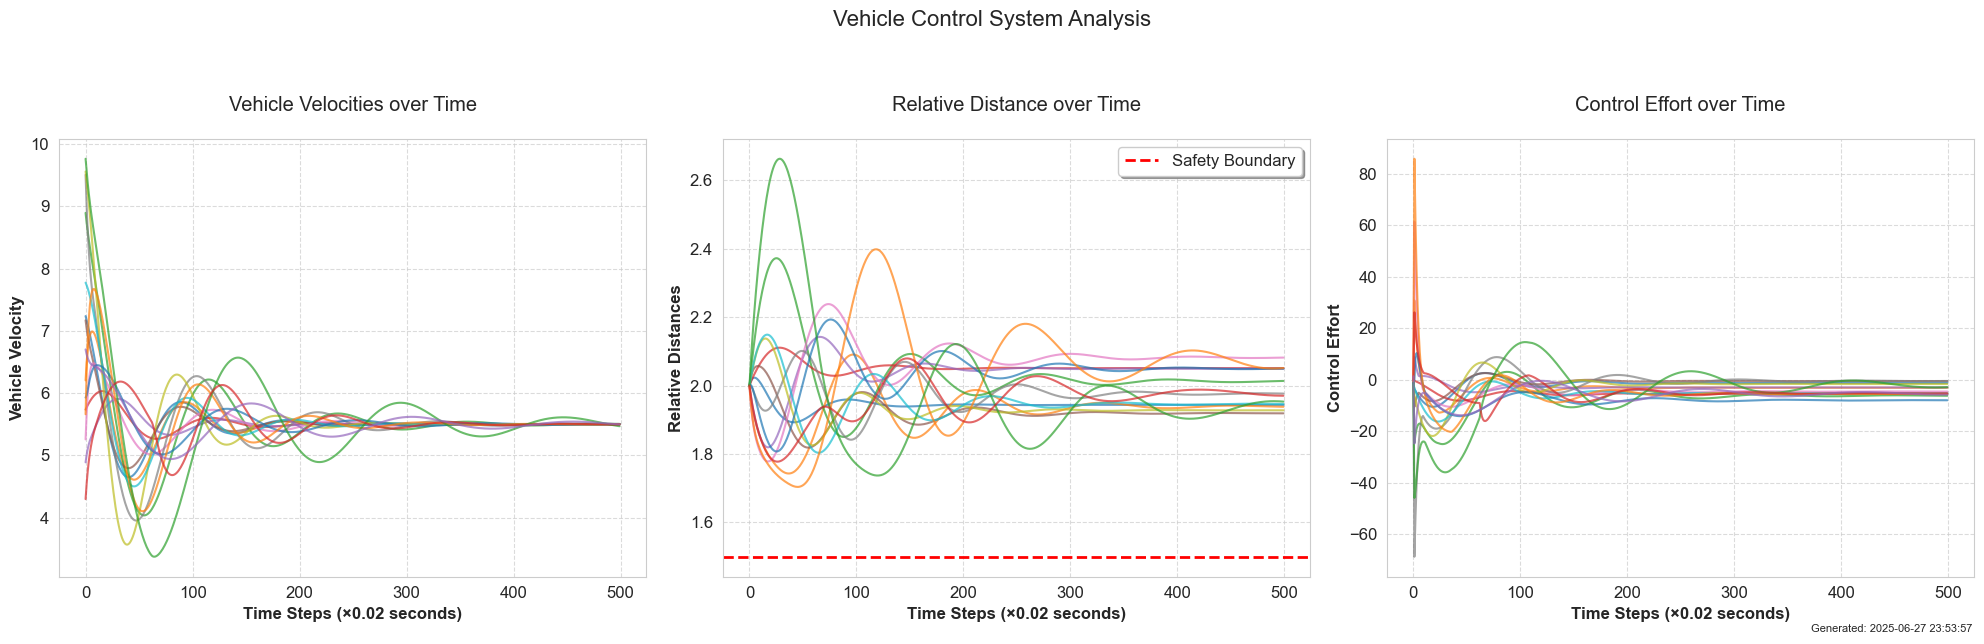

In [67]:
n = 15
delta_t = 0.01
steps = int(5*(1/delta_t))
Imatrix = -scipy.sparse.csr_matrix.toarray(incidence_matrix(path_graph(n=n), oriented=True))
graph = VP(size = n,incidenceMatrix=Imatrix,proportional_term=1,intergration_term=50,delta_t=delta_t,
            solver='daqp',steps = steps)
### set initial condition with shared values across methods 
graph.x = np.copy(X)
graph._eta = np.copy(Eta) 
graph._lambda = np.copy(Lambda)
graph._kappa = np.copy(Kappa)
graph._rho = np.copy(Rho) 
graph.gamma = np.copy(Gamma)
U, relative_d, velocities = graph.update()
plot_vehicle_control_analysis(velocities, relative_d, U, n)

### VP Robust Safety 

In [ ]:
@jit(nopython=True)
def _compute_system_update(x, u, kappa, lambda_val, rho, delta_t):
    return x + delta_t * (kappa * (-(x - lambda_val) + (1/rho)*u))


class VP():
    def __init__(self,size:int,incidenceMatrix:np.ndarray,proportional_term:float,
                 intergration_term:float
                 ,delta_t = 0.01,dtype = 'float32',solver = 'osqp',steps= 1):
        available_solvers = {
                                "clarabel": {"algorithm": "Interior point", "API": "Sparse", "license": "Apache-2.0"},
                                "cvxopt": {"algorithm": "Interior point", "API": "Dense", "license": "GPL-3.0"},
                                "daqp": {"algorithm": "Active set", "API": "Dense", "license": "MIT"},
                                "ecos": {"algorithm": "Interior point", "API": "Sparse", "license": "GPL-3.0"},
                                "gurobi": {"algorithm": "Interior point", "API": "Sparse", "license": "Commercial"},
                                "highs": {"algorithm": "Active set", "API": "Sparse", "license": "MIT"},
                                "hpipm": {"algorithm": "Interior point", "API": "Dense", "license": "BSD-2-Clause"},
                                "jaxopt_osqp": {"algorithm": "Augmented Lagrangian", "API": "Dense", "license": "Apache-2.0"},
                                "kvxopt": {"algorithm": "Interior point", "API": "Dense & Sparse", "license": "GPL-3.0"},
                                "mosek": {"algorithm": "Interior point", "API": "Sparse", "license": "Commercial"},
                                "nppro": {"algorithm": "Active set", "API": "Dense", "license": "Commercial"},
                                "osqp": {"algorithm": "Augmented Lagrangian", "API": "Sparse", "license": "Apache-2.0"},
                                "piqp": {"algorithm": "Proximal interior point", "API": "Dense & Sparse", "license": "BSD-2-Clause"},
                                "proxqp": {"algorithm": "Augmented Lagrangian", "API": "Dense & Sparse", "license": "BSD-2-Clause"},
                                "qpalm": {"algorithm": "Augmented Lagrangian", "API": "Sparse", "license": "LGPL-3.0"},
                                "qpax": {"algorithm": "Interior point", "API": "Dense", "license": "MIT"},
                                "qpoases": {"algorithm": "Active set", "API": "Dense", "license": "LGPL-2.1"},
                                "qpswift": {"algorithm": "Interior point", "API": "Sparse", "license": "GPL-3.0"},
                                "quadprog": {"algorithm": "Active set", "API": "Dense", "license": "GPL-2.0"},
                                "scs": {"algorithm": "Augmented Lagrangian", "API": "Sparse", "license": "MIT"},
                                "sip": {"algorithm": "Barrier Augmented Lagrangian", "API": "Sparse", "license": "MIT"},
                            }
        self.steps = steps
        self.dim = size
        self.x = 2*np.random.random((size,1)).astype(dtype) + 5 
        self.E = incidenceMatrix
        self._kappa = (np.ones((size,1),dtype=dtype)-0.1) +0.2 * np.random.random((size,1)) 
        self._rho = np.random.random((size,1)).astype(dtype) + 1
        self._lambda  = np.random.random((size,1)).astype(dtype) + 5
        self.x_bar = 5.5*np.ones((size,1),dtype=dtype)
        self._zeta = np.matmul(self.E.T,self.x)
        self._eta = np.zeros(self._zeta.shape,dtype = dtype) + 2
        self._eta_0 = np.copy(self._eta)
        self._mu = self._eta 
        self.delta_t =delta_t
        self.s = np.zeros((size,1),dtype=dtype)
        self.K_p = proportional_term*np.ones(shape=(self.dim))
        self.K_i = intergration_term*np.ones(shape=(self.dim))
        self.u = (self.K_p*(self.x_bar - self.x)[:,0]).reshape((-1,1)) +(self.K_i*self.s[:,0]).reshape((-1,1))#+np.matmul(-self.E,self._mu)  
        #self.mamad =  (self.K_p*(self.x_bar - self.x)[:,0]).reshape((-1,1)) +(self.K_i*self.s[:,0]).reshape((-1,1))
        self._gamma = self._kappa/self._rho
        self.k1,self.k2 = (10,10)
        self.solver = solver 

		### estimation of parameters 
        self.delta_rho = 0.1*np.ones(shape=self._rho.shape) 
        self.delta_kappa = 1*np.ones(shape=self._kappa.shape)
        self.delta_lambda = 0.5*np.ones(shape=self._lambda.shape)
        
        
        # self._rho_hat = self._rho + self.delta_rho*np.random.random((self._rho.shape))
        # self._kappa_hat = self._kappa + self.delta_kappa*np.random.random((self._kappa.shape))
        # self._lambda_hat = self._lambda +self.delta_lambda*np.random.random((self._lambda.shape))
        # self.gamma_hat = self._kappa_hat/self._rho_hat 
        self._rho_hat = np.ones(shape = self._rho.shape) * 1.5
        self._kappa_hat = np.ones(shape = self._kappa.shape) * 1
        self._lambda_hat = np.ones(shape= self._lambda.shape) * 5.5
        self.gamma_hat = self._kappa_hat/self._rho_hat 


        gamma_hati = self.gamma_hat[0][0]
        gamma_hatj = self.gamma_hat[0][0]
        kappa_hati = self._kappa_hat[0][0]
        kappa_hatj = self._kappa_hat[0][0]
        rho_hati = self._rho_hat[0][0]
        rho_hatj = self._rho_hat[0][0]
        lambda_hati= self._lambda_hat[0][0]
        lambda_hatj= self._lambda_hat[0][0]
        self.delta11 = self.delta_kappa[0]
        self.delta12 = self.delta_kappa[0]
        self.delta21 = kappa_hati*self.delta_lambda[0] + lambda_hati*self.delta_kappa[0] + self.delta_kappa[0]*self.delta_lambda[0]
        self.delta22 = kappa_hati*self.delta_lambda[0] + lambda_hati*self.delta_kappa[0] - self.delta_kappa[0]*self.delta_lambda[0]
        self.delta31 = ((kappa_hati+self.delta_kappa[0])/(rho_hati-self.delta_rho[0]))-(kappa_hati/rho_hati)
        self.delta32 = -((kappa_hati-self.delta_kappa[0])/(rho_hati+self.delta_rho[0]))+(kappa_hati/rho_hati)
    
        self.delta41 = self.delta_kappa[0]
        self.delta42 = self.delta_kappa[0]
        self.delta51 = kappa_hatj*self.delta_lambda[0] + lambda_hatj*self.delta_kappa[0] + self.delta_kappa[0]*self.delta_lambda[0]
        self.delta52 = kappa_hatj*self.delta_lambda[0] + lambda_hatj*self.delta_kappa[0] - self.delta_kappa[0]*self.delta_lambda[0]
        self.delta61 = ((kappa_hatj+self.delta_kappa[0])/(rho_hatj-self.delta_rho[0]))-(kappa_hatj/rho_hatj)
        self.delta62 = -((kappa_hatj+self.delta_kappa[0])/(rho_hatj-self.delta_rho[0]))+(kappa_hatj/rho_hatj)




        ### safety filter optimization parameters

        self.A = np.array([[0,1,-1,0,0,0,0,0,0,0,0,0,0],
                           [0,0,0,1,-1,0,0,0,0,0,0,0,0],
                           [0,0,0,0,0,1,-1,0,0,0,0,0,0],
                           [0,0,0,0,0,0,0,1,-1,0,0,0,0],
                           [0,0,0,0,0,0,0,0,0,1,-1,0,0],
                           [0,0,0,0,0,0,0,0,0,0,0,1,-1]]).astype('float64')
        self.lb = -np.inf*np.ones((13,1))
        self.ub = np.zeros((13,1))
        self.ub[0] = +np.inf
        self.P = 2*np.eye(13)
        self.Q = np.zeros((13,1))
        self.G = np.array([[0],
                    [-kappa_hati-self.delta11[0]],
                    [kappa_hati-self.delta12[0]],
                    [-kappa_hati*lambda_hati- self.delta21[0]],
                    [kappa_hati*lambda_hati - self.delta22[0]],
                    [-kappa_hatj-self.delta41[0]],
                    [kappa_hatj-self.delta42[0]],
                    [-kappa_hatj*lambda_hatj-self.delta51[0]],
                    [kappa_hatj*lambda_hatj-self.delta52[0]],
                    [-self.delta31[0]],
                    [-self.delta32[0]],
                    [-self.delta61[0]],
                    [-self.delta62[0]]]).T
        if available_solvers[self.solver]['API']== 'Sparse':
            self.P = scipy.sparse.csc_matrix(self.P)
            self.A =  scipy.sparse.csc_matrix(self.A)
            self.G = scipy.sparse.csc_matrix(self.G)
        self.__copy_initial_values()
        self.mode = 'optimization'
        # Initialize B vector
        self.B = np.zeros((6, 1))

    def set_mode(self,mode:str):
        """
        modes: ['optimization','simulation']
        """
        self.mode = mode
    


    def __copy_initial_values(self):
        self.x_init = np.copy(self.x)
        self.x_bar_init = np.copy(self.x_bar)
        self.s_init = np.copy(self.s)
        self._eta_init = np.copy(self._eta)
        self._mu_init = np.copy(self._mu)
        self._zeta_init = np.copy(self._zeta)
        self.u_init = np.copy(self.u)

    def reset(self):
        self.x = np.copy(self.x_init)
        self.x_bar = np.copy(self.x_bar_init)
        self.s = np.copy(self.s_init)
        self._eta = np.copy(self._eta_init)
        self._mu = np.copy(self._mu_init)
        self._zeta = np.copy(self._zeta_init)
        self.u = np.copy(self.u_init)



    def update(self,x):
        """
        x[0] is k1 \\
        x[1] is k2 \\
        x[2] is p \\
        x[3] is i 
        """
        self.reset()
        self.k1=x[-2]
        self.k2 = x[-1]
        self.K_p = x[:self.dim]
        self.K_i = x[self.dim:2*self.dim] 

        # Pre-allocate arrays
        relative_d = np.zeros((self._eta.shape[0], self.steps))
        velocities = np.zeros((self.x.shape[0], self.steps))
        U = np.zeros((self.mamad.shape[0], self.steps))
        
        # Pre-compute constant matrices
        ET = self.E.T
        
        for step in range(self.steps):
            # Store current state
            U[:, step] = self.u[:, 0]
            velocities[:, step] = self.x[:, 0]
            relative_d[:, step] = self._eta[:, 0]

            # Vectorized computations
            self._zeta = ET @ self.x
            self._eta += self.delta_t * self._zeta
            self._mu = self._eta
            self.s += self.delta_t * (self.x_bar - self.x)
            self.u =  (self.K_p*(self.x_bar - self.x)[:,0]).reshape((-1,1)) +(self.K_i*self.s[:,0]).reshape((-1,1))#+np.matmul(-self.E,self._mu)  
            self.mamad =  (self.K_p*(self.x_bar - self.x)[:,0]).reshape((-1,1)) +(self.K_i*self.s[:,0]).reshape((-1,1))

            # Vectorized alpha calculations
            alpha_1 = self.k1 * (self._eta**2 - 1.8**2)
            alpha_2 = self.k2 * (2*self._eta*(ET @ self.x) + alpha_1)
            self.alpha = alpha_2

            alpha_1_prim = self.k1 * np.ones_like(self._eta)
            v = 2*(ET @ self.x)**2 + 2*self._eta*(ET @ self.x)*alpha_1_prim + alpha_2

            # Optimization loop 
            for i in range(0, self.dim-1):
                l, j = i, i+1
                xi = self.x[i, 0]
                xj = self.x[j, 0]
                eta_l = self._eta[l, 0]
                ui = self.u[i, 0]
                gamma_hati = self.gamma_hat[i, 0]
                gamma_hatj = self.gamma_hat[j, 0]

                self.A[-1, 0] = 2*eta_l
                # Update B vector components in-place
                self.B[0, 0] = -2*eta_l*xi
                self.B[1, 0] = 2*eta_l
                self.B[2, 0] = 2*eta_l*xj
                self.B[3, 0] = -2*eta_l  
                self.B[4, 0] = 2*eta_l*ui
                self.B[5, 0] = 0

                self.H = v[l] + 2*eta_l*gamma_hati*ui
                self.G[0, 0] = 2*eta_l*gamma_hatj
                self.Q[0] = -2*self.u[j]

                try:
                    O = solve_qp(P=self.P, q=self.Q, G=self.G, h=self.H, A=self.A, 
                               b=self.B, lb=self.lb, ub=self.ub, solver=self.solver)
                    self.u[j] = O[0]
                except:
                    return +np.inf

            # Use JIT-compiled function for system update
            self.x = _compute_system_update(
                self.x, self.u, self._kappa, self._lambda, self._rho, self.delta_t
            )



    

        if self.mode == 'simulation':
            return U, relative_d, velocities
        else:
            
            #velocities = self.normalize(velocities,velocities)
            #self.x_bar = self.normalize(self.x_bar,velocities)
            return self.TV(U) #+ U.__abs__().sum() + (velocities - self.x_bar).__abs__().sum() 
        #return (U,velocities,relative_d)
    def normalize(self,x,y): 
        return (x - y.min(axis = 1).reshape(-1,1))/(y.max(axis = 1).reshape(-1,1)-y.min(axis = 1).reshape(-1,1))
    def TV(self,x): 
        return np.exp(((np.diff(x,n=1).__abs__() - 1))).sum()


#### simulation

In [ ]:
n = 15
delta_t = 0.01
steps = int(5*(1/delta_t))

Imatrix = -scipy.sparse.csr_matrix.toarray(incidence_matrix(path_graph(n=n), oriented=True))
graph = VP(size = n,incidenceMatrix=Imatrix,proportional_term=10,intergration_term=50,delta_t=delta_t,
            solver='daqp',steps = steps)




# Set style
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

# Create figure
fig = plt.figure(figsize=(20, 6))
fig.suptitle('Vehicle Control System Analysis', fontsize=16, y=1.05)

# Color palette
colors = sns.color_palette("husl", n_colors=n)

# Subplot 1: Vehicle Velocities
plt.subplot(1, 3, 1)
plt.plot(velocities[:,:].T, linewidth=1.5, alpha=0.7)
plt.xlabel('Time Steps (×0.02 seconds)', fontweight='bold')
plt.ylabel('Vehicle Velocity', fontweight='bold')
plt.title('Vehicle Velocities over Time', pad=20)
plt.grid(True, linestyle='--', alpha=0.7)

# Subplot 2: Relative Distances
plt.subplot(1, 3, 2)
plt.plot(relative_d[:,:].T, linewidth=1.5, alpha=0.7)
plt.axhline(y=1.5, color='red', linestyle='--', label='Safety Boundary', linewidth=2)
plt.legend(loc='upper right', frameon=True, fancybox=True, shadow=True)
plt.xlabel('Time Steps (×0.02 seconds)', fontweight='bold')
plt.ylabel('Relative Distances', fontweight='bold')
plt.title('Relative Distance over Time', pad=20)
plt.grid(True, linestyle='--', alpha=0.7)

# Subplot 3: Control Effort
plt.subplot(1, 3, 3)
plt.plot(U[:,:].T, linewidth=1.5, alpha=0.7)
plt.xlabel('Time Steps (×0.02 seconds)', fontweight='bold')
plt.ylabel('Control Effort', fontweight='bold')
plt.title('Control Effort over Time', pad=20)
plt.grid(True, linestyle='--', alpha=0.7)

# Add timestamp
timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
plt.figtext(0.99, 0.01, f'Generated: {timestamp}', ha='right', va='bottom', fontsize=8)

# Adjust layout
plt.tight_layout()
plt.show()

### VP Robust safety with tunned parameters 

#### tunning step 

In [ ]:
lb =np.ones(2*n+2)
ub = 1000*np.ones(2*n+2)
graph.set_mode('optimization')
pso(graph.update, lb, ub,swarmsize=100,maxiter=150,debug=True,phig=0.3,phip=0.8,minstep=1e-11,minfunc=1e-11)

##### tunned paramters 

In [ ]:
graph.set_mode('simulation')

U,relative_d,velocities = graph.update(  [7.05231545,  70.23290756,  55.22709498,  80.36245948,
        100.        ,  98.48876245,  83.769239  ,  85.26504548,
         99.98844387,  93.68812377,  92.9282099 ,  89.54666797,
         85.91760782,  99.8423346 ,  78.63404454,  81.56115642,
         61.12616031,  61.6306044 ,  59.96095496,  43.09050033,
         27.03321129,  53.12250592,  16.87515839,  45.39237898,
         84.46044144,  77.93912359,  76.9498996 ,  26.87250691,
         72.02182974,  93.07503972,  38.10968571,  46.24984835])

#### simulation 

In [ ]:
import seaborn as sns
from datetime import datetime

# Set style
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

# Create figure
fig = plt.figure(figsize=(20, 6))
fig.suptitle('Vehicle Control System Analysis', fontsize=16, y=1.05)

# Color palette
colors = sns.color_palette("husl", n_colors=n)

# Subplot 1: Vehicle Velocities
plt.subplot(1, 3, 1)
plt.plot(velocities[:,:].T, linewidth=1.5, alpha=0.7)
plt.xlabel('Time Steps (×0.02 seconds)', fontweight='bold')
plt.ylabel('Vehicle Velocity', fontweight='bold')
plt.title('Vehicle Velocities over Time', pad=20)
plt.grid(True, linestyle='--', alpha=0.7)

# Subplot 2: Relative Distances
plt.subplot(1, 3, 2)
plt.plot(relative_d[:,:].T, linewidth=1.5, alpha=0.7)
plt.axhline(y=1.5, color='red', linestyle='--', label='Safety Boundary', linewidth=2)
plt.legend(loc='upper right', frameon=True, fancybox=True, shadow=True)
plt.xlabel('Time Steps (×0.02 seconds)', fontweight='bold')
plt.ylabel('Relative Distances', fontweight='bold')
plt.title('Relative Distance over Time', pad=20)
plt.grid(True, linestyle='--', alpha=0.7)

# Subplot 3: Control Effort
plt.subplot(1, 3, 3)
plt.plot(U[:,:].T, linewidth=1.5, alpha=0.7)
plt.xlabel('Time Steps (×0.02 seconds)', fontweight='bold')
plt.ylabel('Control Effort', fontweight='bold')
plt.title('Control Effort over Time', pad=20)
plt.grid(True, linestyle='--', alpha=0.7)

# Add timestamp
timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
plt.figtext(0.99, 0.01, f'Generated: {timestamp}', ha='right', va='bottom', fontsize=8)

# Adjust layout
plt.tight_layout()
plt.show()